In [501]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

### Подготовка данных

Скачаем данные.

In [2]:
mosprime = pd.read_csv('mosprime.csv', sep=';', encoding = 'CP1251')

In [3]:
mosprime.head()

,Date,ON,1W,2W,1M,2M,3M,6M
0,22.12.2017,7.89,7.91,7.91,7.9,7.92,7.9,7.87
1,21.12.2017,7.88,7.91,7.91,7.9,7.92,7.89,7.87
2,20.12.2017,7.9,7.91,7.91,7.9,7.9,7.87,7.87
3,19.12.2017,7.93,7.91,7.91,7.9,7.9,7.88,7.88
4,18.12.2017,7.92,7.96,7.99,7.95,7.98,7.96,7.96


Добавим дату в качестве индекса и оставим только трехмесячные ставки.

In [4]:
mosprime.index = np.array([datetime.strptime(i, '%d.%m.%Y') for i in  mosprime.Date])

In [5]:
mosprime3m = mosprime['3M']

Конвертируем в числовой формат.

In [502]:
mosprime3m = mosprime3m.convert_objects(convert_numeric=True)

In [7]:
mosprime3m.head()

2017-12-22    7.90
2017-12-21    7.89
2017-12-20    7.87
2017-12-19    7.88
2017-12-18    7.96
Name: 3M, dtype: float64

Найдем число пропущенных значений. Посмотрим, в какие дни они были.

In [8]:
np.sum(mosprime3m.isnull())

9

In [9]:
mosprime3m[mosprime3m.isnull()]

2016-03-07   NaN
2016-02-22   NaN
2016-01-06   NaN
2016-01-05   NaN
2015-01-09   NaN
2015-01-08   NaN
2015-01-06   NaN
2011-09-29   NaN
2008-08-21   NaN
Name: 3M, dtype: float64

Кроме того, для некоторых дней просто нет данных, посмотрим, сколько всего таких дней и как они распределены:

In [10]:
da = pd.date_range(start = mosprime3m.index[-1], end = mosprime3m.index[0], freq='d')

In [11]:
len(da)-len(mosprime3m)

1271

In [12]:
dummy_date = np.array([ 1 if i in mosprime3m.index else 0 for i in da])

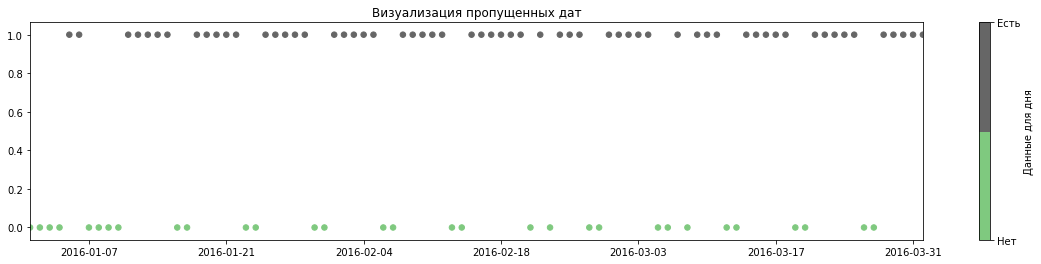

In [13]:
plt.figure(figsize=[20,4])
sp = plt.scatter(da, dummy_date, c = dummy_date,  cmap=plt.cm.get_cmap('Accent', 2) , alpha = 2,  s = 30, label = 'sd')
plt.xlim(['2016-01-01', '2016-04-01'])
plt.title('Визуализация пропущенных дат')
cb = plt.colorbar(sp)
cb.set_ticks([0,1])
cb.set_ticklabels(["Нет", "Есть"])
cb.set_label(r'Данные для дня')
plt.show()

Можно также посмотреть на то, для какого дня недели отсутствуют данные.

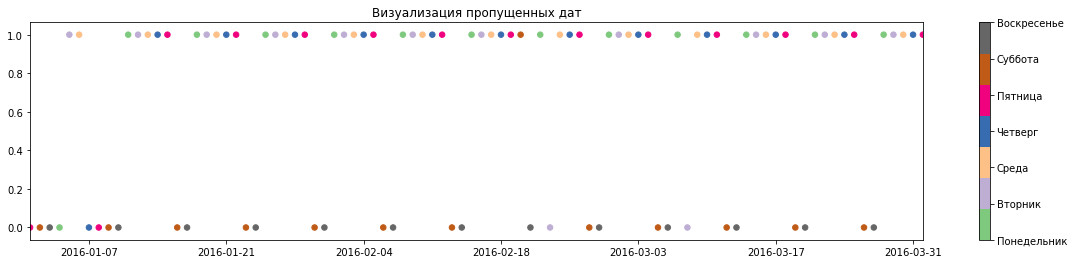

In [14]:
plt.figure(figsize=[20,4])
sp = plt.scatter(da, dummy_date, c = da.dayofweek, cmap=plt.cm.get_cmap('Accent', 7),
                 alpha = 2, s = 30, label = 'sd')
plt.xlim(['2016-01-01', '2016-04-01'])
plt.title('Визуализация пропущенных дат')
cb = plt.colorbar(sp)
cb.set_ticks([0,1,2,3,4,5,6])
cb.set_ticklabels(["Понедельник", "Вторник","Среда","Четверг","Пятница","Суббота","Воскресенье",])
plt.show()

Вполне ожидаемо, что это оказались выходные и праздничные дни.

### Калибровка моделей

Наш временной ряд выглядит следующим образом:

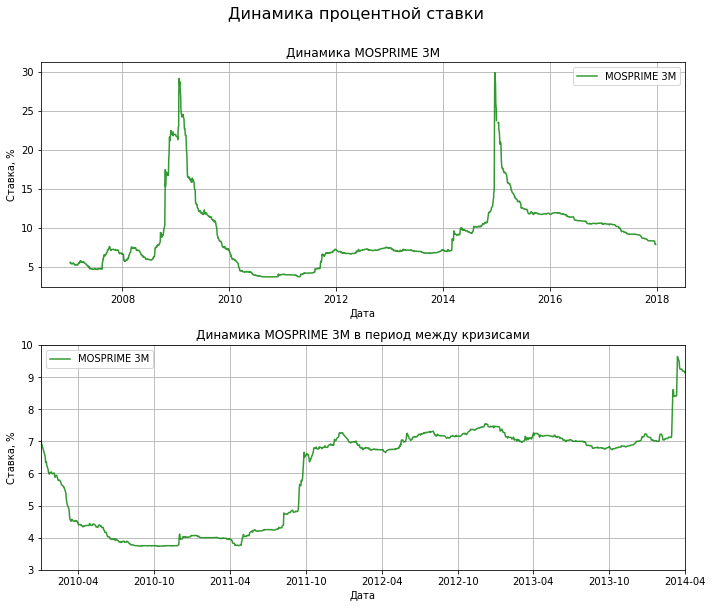

In [15]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)
plt.plot(mosprime3m , 'g-',  alpha = 0.8, label = 'MOSPRIME 3M')
plt.title('Динамика MOSPRIME 3M')
plt.xlabel('Дата') 
plt.ylabel('Ставка, %')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(mosprime3m , 'g-',  alpha = 0.8, label = 'MOSPRIME 3M')
plt.xlim(['2010-01-01', '2014-04-01'])
plt.ylim([3,10])
plt.title('Динамика MOSPRIME 3M в период между кризисами')
plt.xlabel('Дата') 
plt.ylabel('Ставка, %')
plt.legend()
plt.grid()

plt.suptitle('Динамика процентной ставки' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

Вид графиков, а в особенности два пика, позволяют сделать предварительное заключение о необходимости отдельной калибровки для кризисных и обычных периодов.

In [16]:
mosprime3m_between = mosprime3m[np.array([ True if i in pd.date_range(start = '2010-04-01',
                                                                      end = '2013-04-01',
                                                                      freq='d') 
                                          else False for i in mosprime3m.index]
                                        )].sort_index(axis=0, ascending=True)

Но для текущих целей выберем еще более короткий временной промежуток, чтобы ускорить вычисления.

In [17]:
mosprime3m_short = mosprime3m[np.array([ True if i in pd.date_range(start = '2012-04-01',
                                                                      end = '2012-09-01',
                                                                      freq='d') 
                                          else False for i in mosprime3m.index]
                                        )].sort_index(axis=0, ascending=True)

### Модель Мертона

\begin{equation}
dr_t = \alpha dt + \sigma dW_t
\end{equation}

Сначала для примера приведем просто случайную симуляцию.

In [20]:
def simulate_merton():
    # параметры модели
    r0 = 6 # начальная ставка
    T = 3.0 # число лет
    a = 0.05 # альфа 
    vol = 0.2 # волатильность
    # симуляция
    #np.random.seed(250000)
    merton_dates = pd.DatetimeIndex(start='2010-04-01',
    end='2013-04-01',
    freq='B')
    M = len(merton_dates) 
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((M, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, M): 
        r[t] = r[t - 1] +  a*dt + vol * rand[t] * np.sqrt(dt)
    merton = pd.DataFrame(r[:, 0], index=merton_dates, columns=['index'])
    merton = merton.dropna()
    return merton

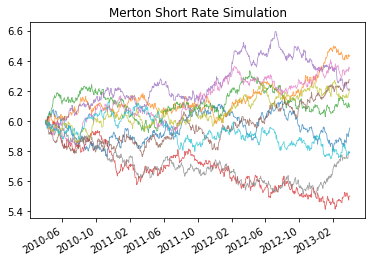

In [21]:
num_paths = 10
for i in range(num_paths):
    plt.plot(simulate_merton(), lw=0.8, alpha=0.7)
plt.title("Merton Short Rate Simulation")
plt.gcf().autofmt_xdate()
plt.tight_layout
plt.show()

##### MAPE-ошибка

В качестве первого метода оптимизации будем минимизировать MAPE между истинными значениями и сгенерированной траектории случайного процесса.

In [55]:
data = mosprime3m_short

In [56]:
import scipy.optimize as sop

In [138]:
def merton_path(r0, days, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a*dt + vol * rand[t] * np.sqrt(dt)
    merton = pd.DataFrame(r[:, 0], columns=['index'])
    merton = merton.values.flatten()
    return merton

In [139]:
def Merton_error_function(p0):
    global i, min_error
    r0 = data[0]
    a, vol = p0
    if a < 0.0 or vol < 0.0:
        return 500.0
    se = []
    days = len(data)
    #RMSE = np.sqrt(np.nanmean((data - merton_path(r0, days, a, vol))**2))
    MAPE = 100*np.nanmean(np.absolute((data - merton_path(r0, days, a, vol))/data))
    error = MAPE
    min_error = min(min_error, error)
    #if i % 10 == 0:
        #print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (error, min_error))
    i += 1
    return error

In [513]:

# Калибровка
i = 0 
min_error = 100 
p0 = sop.brute(Merton_error_function, ((0.075, 0.201, 0.025),
(0.10, 0.401, 0.1)), finish=None)
#p0 = [0.04, 0.2]
opt = sop.fmin(Merton_error_function, p0,
               maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)


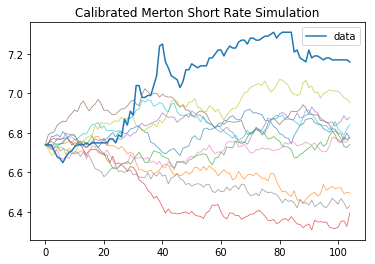

In [146]:
num_paths = 10
for i in range(num_paths):
    plt.plot(merton_path(data[0], len(data), opt[0], opt[1]), lw=0.8, alpha=0.7)
plt.title("Calibrated Merton Short Rate Simulation")
plt.plot(data.values.flatten(), label = 'data')
plt.legend()
plt.tight_layout
plt.show()

Повторим эту операцию 100 раз и построим траектории лучшей из них.

In [514]:
def sim_opt_merton(iters):
    glob_opt = []
    glob_opt_error = 100
    for j in range(iters):
        i = 0 # counter initialization
        min_error = 100 # minimal MAPE initialization
        opt = sop.fmin(Merton_error_function, p0,
                       maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)
        if Merton_error_function(opt) < glob_opt_error:
            glob_opt_error = Merton_error_function(opt)
            glob_opt = opt
        else:
            glob_opt_error = glob_opt_error
            glob_opt = glob_opt
    return glob_opt
 

In [515]:
glob_opt = sim_opt_merton(100)

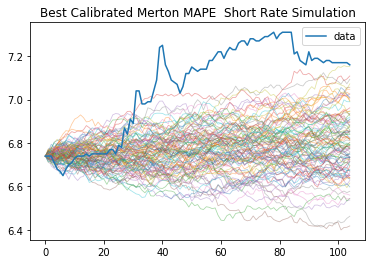

In [516]:
num_paths = 100
for i in range(num_paths):
    plt.plot(merton_path(data[0], len(data), glob_opt[0],
                      glob_opt[1]), lw=0.8, alpha=0.4)
plt.title("Best Calibrated Merton MAPE  Short Rate Simulation")
plt.plot(data.values.flatten(), label = 'data')
plt.legend()
plt.tight_layout
plt.show()

##### Максимальное правдоподобие

В данном случае процентная ставка в момент $t$ имеет нормальное распределение со следующими параметрами:
    
\begin{equation}
E(r_t) = \alpha t
\end{equation}

\begin{equation}
Var(r_t) = \sigma^2 t
\end{equation}

In [495]:
p0 = sop.brute(Merton_error_function, ((0.075, 0.201, 0.025),
(0.10, 0.401, 0.1)), finish=None)

In [496]:
p0

array([ 0.15,  0.4 ])

In [497]:
def dN(x, mu, sigma):
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
    return pdf

In [498]:
def merton_ll(p0):
    a, vol = p0
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    L = -np.prod(dN(x, mu, sigma))
    return L

In [499]:
opt = sop.fmin(merton_ll, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

Optimization terminated successfully.
         Current function value: -11645170461823123064184616752513024.000000
         Iterations: 126
         Function evaluations: 280


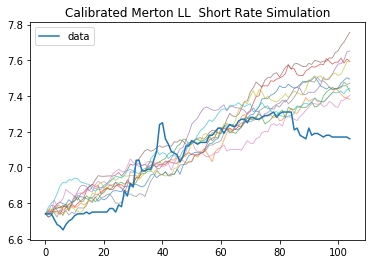

In [500]:
num_paths = 10
for i in range(num_paths):
    plt.plot(merton_path(data[0], len(data), opt[0], 
                         opt[1]), lw=0.8, alpha=0.7)
plt.title("Calibrated Merton LL  Short Rate Simulation")
plt.plot(data.values.flatten(), label = 'data')
plt.legend()
plt.tight_layout
plt.show()

### Однофакторная модель Hull-White

\begin{equation}
dr_t = (\theta(t) - a r_t) dt + \sigma dW_t\\
\end{equation}

\begin{equation}
\theta(t) := \lambda + \beta t
\end{equation}

Опять симуляция.

In [58]:
def simulate_HW1():
    # параметры модели
    r0 = 6 # начальная ставка
    T = 3.0 # число лет
    a = 0.05 # альфа 
    vol = 0.2 # волатильность
    b = 0.001
    # симуляция
    HW1_dates = pd.DatetimeIndex(start='2010-04-01',
    end='2013-04-01',
    freq='B')
    M = len(HW1_dates) 
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((M, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, M): 
        r[t] = (r[t - 1] +  b * t * dt + vol * rand[t] * np.sqrt(dt))/ (1 + a * dt)
    HW1 = pd.DataFrame(r[:, 0], index=HW1_dates, columns=['index'])
    HW1 = HW1.dropna()
    return HW1

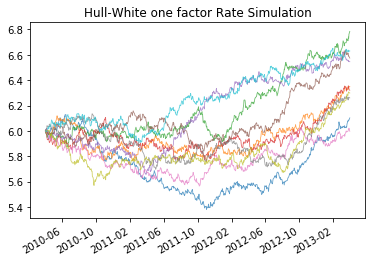

In [59]:
num_paths = 10
for i in range(num_paths):
    plt.plot(simulate_HW1(), lw=0.8, alpha=0.7)
plt.title("Hull-White one factor Rate Simulation")
plt.gcf().autofmt_xdate()
plt.tight_layout
plt.show()

In [517]:
def HW1_path(r0, days, l, b, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    l = l # лямбда
    a = a # альфа 
    b = b # бета
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = (r[t - 1] +  l + b * t * dt + vol * rand[t] * np.sqrt(dt))/ (1 + a * dt)
    HW1 = pd.DataFrame(r[:, 0], columns=['index'])
    HW1 = HW1.values.flatten()
    return HW1

In [518]:
def HW1_error_function(p0):
    global i, min_error
    r0 = data[0]
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0 or b < 0.0 or l < 0.0:
        return 500.0
    se = []
    days = len(data)
    #RMSE = np.sqrt(np.nanmean((data - HW1_path(r0, days, l, b, a, vol))**2))
    MAPE = 100*np.nanmean(np.absolute((data - HW1_path(r0, days, l, b, a, vol))/data))
    error = MAPE
    min_error = min(min_error, error)
    #if i % 10 == 0:
        #print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (error, min_error))
    i += 1
    return error

In [519]:
# Калибровка

i = 0 
min_error = 100 
p0 = sop.brute(HW1_error_function, ((0.10, 0.401, 0.1),
                                    (0.0001, 0.101, 0.025),
                                    (0.075, 0.201, 0.025),
                                    (0.075, 0.201, 0.025)), finish=None)
opt_HW1_error = sop.fmin(HW1_error_function, p0,
               maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)

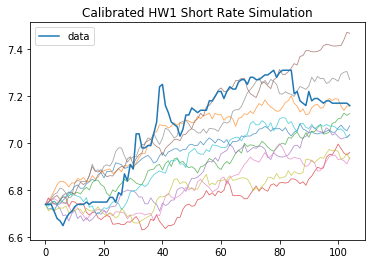

In [520]:
num_paths = 10
for i in range(num_paths):
    plt.plot(HW1_path(data[0], len(data), opt_HW1_error[0], opt_HW1_error[1],
                      opt_HW1_error[2], opt_HW1_error[3]), lw=0.8, alpha=0.7)
plt.title("Calibrated HW1 Short Rate Simulation")
plt.plot(data.values.flatten(), label = 'data')
plt.legend()
plt.tight_layout
plt.show()

In [521]:
def sim_opt_HW1(iters):
    glob_opt = []
    glob_opt_error = 100
    for j in range(iters):
        i = 0 # counter initialization
        min_error = 100 # minimal MAPE initialization
        opt = sop.fmin(HW1_error_function, p0,
                       maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)
        if HW1_error_function(opt) < glob_opt_error:
            glob_opt_error = HW1_error_function(opt)
            glob_opt = opt
        else:
            glob_opt_error = glob_opt_error
            glob_opt = glob_opt
    return glob_opt
 

In [522]:
glob_opt = sim_opt_HW1(100)

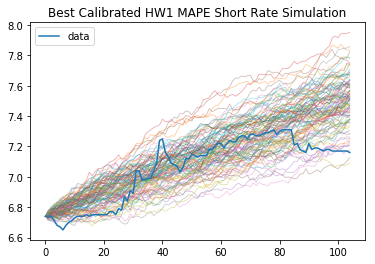

In [523]:
num_paths = 100
for i in range(num_paths):
    plt.plot(HW1_path(data[0], len(data), glob_opt[0],
                      glob_opt[1], glob_opt[2],glob_opt[3]), lw=0.8, alpha=0.4)
plt.title("Best Calibrated HW1 MAPE Short Rate Simulation")
plt.plot(data.values.flatten(), label = 'data')
plt.legend()
plt.tight_layout
plt.show()

##### Максимальное правдоподобие

В данном случае процентная ставка в момент $t$ имеет нормальное распределение со следующими матожиданием и дисперсией:
    
\begin{equation}
E(r_t) = r_0 e^{-\alpha t} + \frac{e^{-\alpha t}(\lambda + \beta t)(1 + e^{\alpha t}(-1 + \alpha t))}{\alpha^2}\\
Var(r_t) = \frac{\sigma^2 }{2 \alpha} (1 - e^{-2\alpha t})
\end{equation}

In [479]:
p0 = opt_HW1_error

In [480]:
p0

array([  1.26181210e-02,   1.12653465e-04,   2.58749534e-01,
         2.28077228e-01])

In [485]:
def HW1_ll(p0):
    l, b, a, vol = p0
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = min(data) * np.exp(-a * t) + np.exp(-a * t)*(l + b * t)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    #mu = min(data) * np.exp(-a * t) + l/a * (1-np.exp(-a * t))
    L = -np.prod(dN(x, mu, sigma))
    return L

In [486]:
opt_HW1_ll = sop.fmin(HW1_ll, p0,
               maxiter=100, maxfun=100, xtol=0.0001, ftol=0.0001)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 9
         Function evaluations: 53


In [487]:
opt_HW1_ll

array([  1.26181210e-02,   1.12653465e-04,   2.58749534e-01,
         2.28077228e-01])

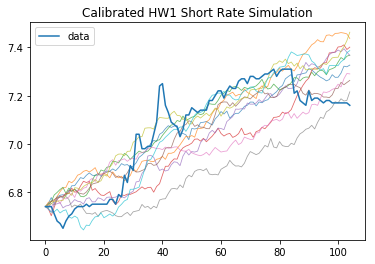

In [490]:
num_paths = 10
for i in range(num_paths):
    plt.plot(HW1_path(data[0], len(data), opt[0], opt[1], opt[2], opt[3]), lw=0.8, alpha=0.7)
plt.title("Calibrated HW1 Short Rate Simulation")
plt.plot(data.values.flatten(), label = 'data')
plt.legend()
plt.tight_layout
plt.show()

В целом метод максимального правдоподобия дает более реалистичные траектории, кроме того, он быстрее считается. Однако вероятно, что можно более удачно реализовать оптимизацию ошибки, но пока в этом нет смысла.

### Иллюстрация пакета QuantLib-Python на искусственном примере

В этом блоке просто привожу пример готового пакета для калибровки параметров. Но так как он это делает по опционам, то для текущего этапа данный метод не подходит.

In [237]:
#!pip install QuantLib-Python

In [16]:
import QuantLib as ql
from collections import namedtuple
import math

#### Hull-White 1 Factor Model 

\begin{equation}
dr_t = (\theta(t) - a r_t) dt + \sigma dW_t
\end{equation}

In [17]:
today = ql.Date(1, ql.April, 2010);
settlement= ql.Date(1, ql.April, 2013);
ql.Settings.instance().evaluationDate = today;
term_structure = ql.YieldTermStructureHandle(
    ql.FlatForward(settlement,0.04875825,ql.Actual365Fixed())
    )
index = ql.Euribor1Y(term_structure)

In [18]:
CalibrationData = namedtuple("CalibrationData", 
                             "start, length, volatility")
data = [CalibrationData(1, 5, 0.1148),
        CalibrationData(2, 4, 0.1108),
        CalibrationData(3, 3, 0.1070),
        CalibrationData(4, 2, 0.1021),
        CalibrationData(5, 1, 0.1000 )]

In [19]:
CalibrationData(1, 5, 0.1148)

CalibrationData(start=1, length=5, volatility=0.1148)

In [20]:
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_tenor = ql.Period(1, ql.Years)
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start, ql.Years),
                                   ql.Period(d.length, ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

def calibration_report(swaptions, data):
    print("-"*82)
    print("%15s %15s %15s %15s %15s" % \
    ("Model Price", "Market Price", "Implied Vol", "Market Vol", "Rel Error"))
    print("-"*82)
    cum_err = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i].volatility
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
                                          1e-5, 50, 0.0, 0.50)
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error2*rel_error2
        
        print("%15.5f %15.5f %15.5f %15.5f %15.5f" % \
        (model_price, black_price, implied_vol, market_vol, rel_error))
    print("-"*82)
    print("Cumulative Error : %15.5f" % math.sqrt(cum_err))

In [21]:
model = ql.HullWhite(term_structure);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model.params()
print("a = %6.5f, sigma = %6.5f" % (a, sigma))

a = 0.04733, sigma = 0.00820


In [22]:
calibration_report(swaptions, data)

----------------------------------------------------------------------------------
    Model Price    Market Price     Implied Vol      Market Vol       Rel Error
----------------------------------------------------------------------------------
        0.01237         0.01884         0.07526         0.11480        -0.34360
        0.01361         0.01586         0.09505         0.11080        -0.14158
        0.01218         0.01225         0.10631         0.10700        -0.00637
        0.00915         0.00821         0.11380         0.10210         0.11373
        0.00499         0.00419         0.11921         0.10000         0.19045
----------------------------------------------------------------------------------
Cumulative Error :         0.43463


Нарисуем траектории процесса при заданных параметрах.

In [28]:
sigma = 0.00820
a = 0.04733
timestep = 360
length = 4 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2015)

In [29]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

In [30]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [31]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

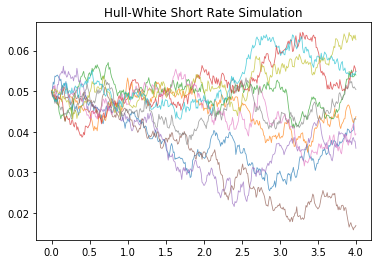

In [32]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.7)
plt.title("Hull-White Short Rate Simulation")
plt.show()